# CLDN16
[hypomagnesemia-3 (HOMG3)](https://omim.org/entry/248250) is caused by homozygous or compound heterozygous mutation in the claudin-16 gene (CLDN16).

> [Godron A, et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22422540/) analyzed 32 individuals with CLD16 and CLD19 variants and concluded that
CLDN19 mutations may display more severe renal impairment than patients with CLDN16 mutations.

> [Radonsky V, et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/32710267/) suggest a correlation with large CLDN16 deletions and severe phenotypes but do not provide narrative or statistical evidence.

In [3]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


### CLDN16
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CLDN16.

In [1]:
gene_symbol = 'CLDN16'
mane_tx_id = 'NM_006580.4'
mane_protein_id = 'NP_006571.2' # claudin-16

In [7]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 46 phenopackets
Individuals Processed: 100%|██████████| 46/46 [00:06<00:00,  7.50individuals/s]
Validated under permissive policy
No errors or warnings were found


In [8]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Nephrocalcinosis,HP:0000121,46
Hypercalciuria,HP:0002150,41
Hypermagnesiuria,HP:0012608,32
Renal insufficiency,HP:0000083,32
Renal magnesium wasting,HP:0005567,30
Elevated circulating parathyroid hormone level,HP:0003165,29
Polyuria,HP:0000103,23
Polydipsia,HP:0001959,22
Hypomagnesemia,HP:0002917,20
Recurrent urinary tract infections,HP:0000010,16


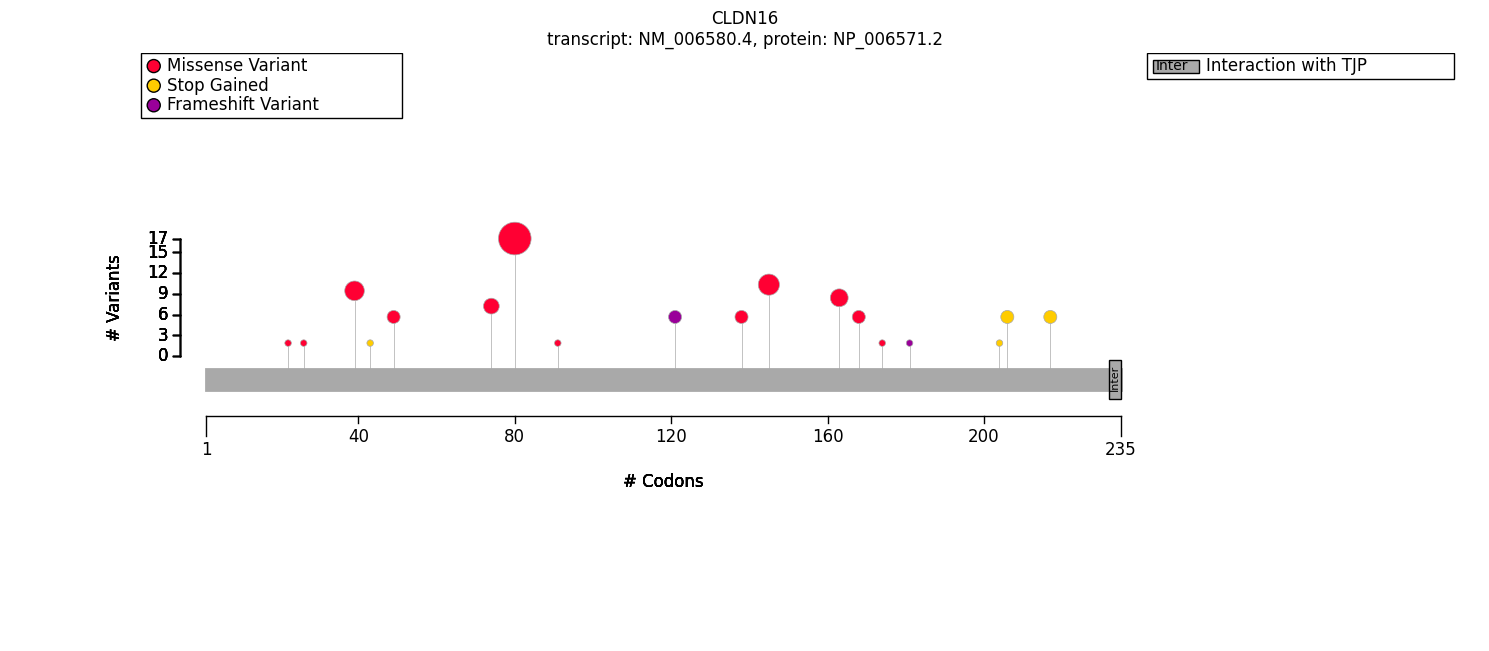

In [12]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
#protein_meta = pms.annotate(mane_protein_id)


protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="CLDN16",
        uniprot_json="Q9Y5I7.json",
        protein_length=235,
)


fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

# Strategy

In [20]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.model import FeatureType
from gpsea.analysis.predicate import PatientCategories
from gpsea.view import MtcStatsViewer
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.mtc_filter import UseAllTermsMtcFilter
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.pcats import HpoTermAnalysis


pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)

mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.1)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

count_statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)


In [25]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_recessive,VariantPredicate, biallelic_predicate
from gpsea.model import VariantEffect
from gpsea.view import summarize_hpo_analysis

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    names=("A", "B"),
    partitions = ({0,1}, {2})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


gt_predicate.display_question()
summarize_hpo_analysis(hpo=hpo, result=result)


Allele group                                       A/A OR A/B           B/B  \
                                                        Count Percent Count   
Stage 5 chronic kidney disease [HP:0003774]              2/35      6%  5/10   
Nephrolithiasis [HP:0000787]                             7/30     23%   2/2   
Hypocalcemia [HP:0002901]                                 8/9     89%   3/7   
Failure to thrive [HP:0001508]                           7/24     29%   1/1   
Abdominal pain [HP:0002027]                              8/24     33%   1/1   
Hypercalciuria [HP:0002150]                             32/36     89%   9/9   
Recurrent urinary tract infections [HP:0000010]         13/26     50%   3/4   
Hypermagnesiuria [HP:0012608]                           25/27     93%   7/7   
Elevated circulating parathyroid hormone level ...      25/26     96%   4/4   
Polyuria [HP:0000103]                                   20/25     80%   3/3   
Polydipsia [HP:0001959]                                 19/24     79%   3/3   
Hypomagnesemia [HP:0002917]                             11/12     92%   9/9   
Hypocalcemic seizures [HP:0002199]                        2/5     40%   1/5   

Allele group                                                                   \
                                                   Percent Corrected p values   
Stage 5 chronic kidney disease [HP:0003774]            50%           0.045094   
Nephrolithiasis [HP:0000787]                          100%           0.458333   
Hypocalcemia [HP:0002901]                              43%           0.458333   
Failure to thrive [HP:0001508]                        100%           0.936000   
Abdominal pain [HP:0002027]                           100%           0.936000   
Hypercalciuria [HP:0002150]                           100%           1.000000   
Recurrent urinary tract infections [HP:0000010]        75%           1.000000   
Hypermagnesiuria [HP:0012608]                         100%           1.000000   
Elevated circulating parathyroid hormone level ...    100%           1.000000   
Polyuria [HP:0000103]                                 100%           1.000000   
Polydipsia [HP:0001959]                               100%           1.000000   
Hypomagnesemia [HP:0002917]                           100%           1.000000   
Hypocalcemic seizures [HP:0002199]                     20%           1.000000   

Allele group                                                  
                                                    p values  
Stage 5 chronic kidney disease [HP:0003774]         0.003469  
Nephrolithiasis [HP:0000787]                        0.072581  
Hypocalcemia [HP:0002901]                           0.105769  
Failure to thrive [HP:0001508]                      0.320000  
Abdominal pain [HP:0002027]                         0.360000  
Hypercalciuria [HP:0002150]                         0.568710  
Recurrent urinary tract infections [HP:0000010]     0.601533  
Hypermagnesiuria [HP:0012608]                       1.000000  
Elevated circulating parathyroid hormone level ...  1.000000  
Polyuria [HP:0000103]                               1.000000  
Polydipsia [HP:0001959]                             1.000000  
Hypomagnesemia [HP:0002917]                         1.000000  
Hypocalcemic seizures [HP:0002199]                  1.000000

In [28]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_recessive
is_var_key = VariantPredicates.variant_key("3_190404787_190404787_G_T") # 			c.243G>T	p.Leu81Phe	
gt_predicate.display_question()
gt_predicate = autosomal_recessive(is_var_key, partitions={(0,1), (2,)})
gt_predicate.display_question()
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         HOM_REF OR HET          \
                                                            Count Percent   
Hyperuricosuria [HP:0003149]                                 8/11     73%   
Failure to thrive [HP:0001508]                               2/12     17%   
Vomiting [HP:0002013]                                        2/11     18%   
Hypercalciuria [HP:0002150]                                 28/32     88%   
Sterile pyuria [HP:0100586]                                  5/11     45%   
Nephrolithiasis [HP:0000787]                                 4/19     21%   
Elevated circulating parathyroid hormone level ...          17/17    100%   
Hypermagnesiuria [HP:0012608]                               19/21     90%   
Tetany [HP:0001281]                                          2/11     18%   
Polyuria [HP:0000103]                                       13/15     87%   
Microscopic hematuria [HP:0002907]                           2/12     17%   
Polydipsia [HP:0001959]                                     12/14     86%   
Stage 5 chronic kidney disease [HP:0003774]                  6/32     19%   
Recurrent urinary tract infections [HP:0000010]             10/17     59%   
Abdominal pain [HP:0002027]                                  4/12     33%   

What is the genotype group                         BIALLELIC_ALT          \
                                                           Count Percent   
Hyperuricosuria [HP:0003149]                                5/13     38%   
Failure to thrive [HP:0001508]                              6/13     46%   
Vomiting [HP:0002013]                                       6/13     46%   
Hypercalciuria [HP:0002150]                                13/13    100%   
Sterile pyuria [HP:0100586]                                 9/13     69%   
Nephrolithiasis [HP:0000787]                                5/13     38%   
Elevated circulating parathyroid hormone level ...         12/13     92%   
Hypermagnesiuria [HP:0012608]                              13/13    100%   
Tetany [HP:0001281]                                         1/13      8%   
Polyuria [HP:0000103]                                      10/13     77%   
Microscopic hematuria [HP:0002907]                          4/13     31%   
Polydipsia [HP:0001959]                                    10/13     77%   
Stage 5 chronic kidney disease [HP:0003774]                 1/13      8%   
Recurrent urinary tract infections [HP:0000010]             6/13     46%   
Abdominal pain [HP:0002027]                                 5/13     38%   

What is the genotype group                                             \
                                                   Corrected p values   
Hyperuricosuria [HP:0003149]                                 0.754463   
Failure to thrive [HP:0001508]                               0.754463   
Vomiting [HP:0002013]                                        0.754463   
Hypercalciuria [HP:0002150]                                  0.754463   
Sterile pyuria [HP:0100586]                                  0.754463   
Nephrolithiasis [HP:0000787]                                 0.754463   
Elevated circulating parathyroid hormone level ...           0.754463   
Hypermagnesiuria [HP:0012608]                                0.754463   
Tetany [HP:0001281]                                          0.754463   
Polyuria [HP:0000103]                                        0.754463   
Microscopic hematuria [HP:0002907]                           0.754463   
Polydipsia [HP:0001959]                                      0.754463   
Stage 5 chronic kidney disease [HP:0003774]                  0.754463   
Recurrent urinary tract infections [HP:0000010]              0.764078   
Abdominal pain [HP:0002027]                                  1.000000   

What is the genotype group                                    
                                                    p values  
Hyperuricosuria [HP:0003149] 

In [29]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex of the individual                              FEMALE           MALE  \
                                                    Count Percent  Count   
Failure to thrive [HP:0001508]                       6/10     60%   2/15   
Tetany [HP:0001281]                                   3/9     33%   0/15   
Hypocitraturia [HP:0012405]                           1/7     14%   9/13   
Abdominal pain [HP:0002027]                          6/10     60%   3/15   
Vomiting [HP:0002013]                                 5/9     56%   3/15   
Rickets [HP:0002748]                                  2/9     22%   0/15   
Stage 5 chronic kidney disease [HP:0003774]          4/18     22%   3/26   
Hypomagnesemia [HP:0002917]                           8/9     89%  11/11   
Hypermagnesiuria [HP:0012608]                       11/11    100%  20/22   
Polydipsia [HP:0001959]                              9/10     90%  13/17   
Polyuria [HP:0000103]                                9/10     90%  14/18   
Microscopic hematuria [HP:0002907]                    3/9     33%   3/16   
Recurrent urinary tract infections [HP:0000010]      6/10     60%   9/19   
Hypercalciuria [HP:0002150]                         16/18     89%  24/26   
Elevated circulating parathyroid hormone level ...  11/11    100%  18/19   
Sterile pyuria [HP:0100586]                           5/9     56%   9/15   
Hyperuricosuria [HP:0003149]                          5/9     56%   8/15   
Hypocalcemia [HP:0002901]                             5/7     71%    6/8   
Nephrolithiasis [HP:0000787]                         3/12     25%   6/20   
Hypocalcemic seizures [HP:0002199]                    2/5     40%    1/4   

Sex of the individual                                                          \
                                                   Percent Corrected p values   
Failure to thrive [HP:0001508]                         13%           0.381837   
Tetany [HP:0001281]                                     0%           0.381837   
Hypocitraturia [HP:0012405]                            69%           0.381837   
Abdominal pain [HP:0002027]                            20%           0.397753   
Vomiting [HP:0002013]                                  20%           0.397753   
Rickets [HP:0002748]                                    0%           0.434783   
Stage 5 chronic kidney disease [HP:0003774]            12%           1.000000   
Hypomagnesemia [HP:0002917]                           100%           1.000000   
Hypermagnesiuria [HP:0012608]                          91%           1.000000   
Polydipsia [HP:0001959]                                76%           1.000000   
Polyuria [HP:0000103]                                  78%           1.000000   
Microscopic hematuria [HP:0002907]                     19%           1.000000   
Recurrent urinary tract infections [HP:0000010]        47%           1.000000   
Hypercalciuria [HP:0002150]                            92%           1.000000   
Elevated circulating parathyroid hormone level ...     95%           1.000000   
Sterile pyuria [HP:0100586]                            60%           1.000000   
Hyperuricosuria [HP:0003149]                           53%           1.000000   
Hypocalcemia [HP:0002901]                              75%           1.000000   
Nephrolithiasis [HP:0000787]                           30%           1.000000   
Hypocalcemic seizures [HP:0002199]                     25%           1.000000   

Sex of the individual                                         
                                                    p values  
Failure to thrive [HP:0001508]                      0.028042  
Tetany [HP:0001281]                                 0.041502  
Hypocitraturia [HP:0012405]                         0.057276  
Abdominal pain [HP:0002027]                         0.087221  
Vomiting [HP:0002013]                               0.099438  
Rickets [HP:0002748]                                0.130435  
Stage 5 chronic kidney disease [HP:00037